## Installation of libraries

In [ ]:
!pip install tf_slim
!pip install tf-models-official
!pip install lvis

     |████████████████████████████████| 352 kB 4.0 MB/s 
     |████████████████████████████████| 1.8 MB 4.2 MB/s 
     |████████████████████████████████| 90 kB 8.9 MB/s 
     |████████████████████████████████| 213 kB 49.1 MB/s 
     |████████████████████████████████| 596 kB 40.8 MB/s 
     |████████████████████████████████| 47.6 MB 37 kB/s 
     |████████████████████████████████| 4.4 MB 14.5 MB/s 
     |████████████████████████████████| 99 kB 8.6 MB/s 
     |████████████████████████████████| 1.2 MB 37.1 MB/s 
     |████████████████████████████████| 43 kB 1.9 MB/s 
     |████████████████████████████████| 1.1 MB 52.8 MB/s 
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=dbede67b9df6ad25e525241eecec0f8d624c0170201aa7ba46e63de1bbb85fd9
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16181 sha256=4ec8139e009787e6e96

## Object Detection library installation

In [ ]:
import os
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
%cd /content/models/
#!git checkout 58d19c67e1d30d905dd5c6e5092348658fed80af
!apt-get update && apt-get install -y -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py

/content
/content/models
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [786 kB]
Hit:13

## Base model decompression

NOTE: Remember to check that the URL is the same as where you have your base model in the Google Colab file system.

In [ ]:
import zipfile

local_zip = "/content/fine_tuned_model.zip"
zip_ref = zipfile.ZipFile(local_zip, "r")
zip_ref.extractall("/content/fine_tuned_model")
zip_ref.close()

In [ ]:
import time
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import tensorflow as tf
import numpy as np

# Revisa que el path coincida con el de la carpeta
PATH_TO_MODEL_DIR = "/content/fine_tuned_model"
PATH_TO_SAVED_MODEL = PATH_TO_MODEL_DIR + "/saved_model"
print('Loading model...', end='')
start_time = time.time()
# Load saved model and build the detection function
detect_fn = tf.saved_model.load(PATH_TO_SAVED_MODEL)
end_time = time.time()
elapsed_time = end_time - start_time
print('Done! Took {} seconds'.format(elapsed_time))

Loading model...Done! Took 25.862757205963135 seconds


In [ ]:
label_map_pbtxt_fname = "/content/label_map.pbtxt"
category_index = label_map_util.create_category_index_from_labelmap(label_map_pbtxt_fname)

## Test the results of our model with an image

Running inference for /content/prueba5.png... 

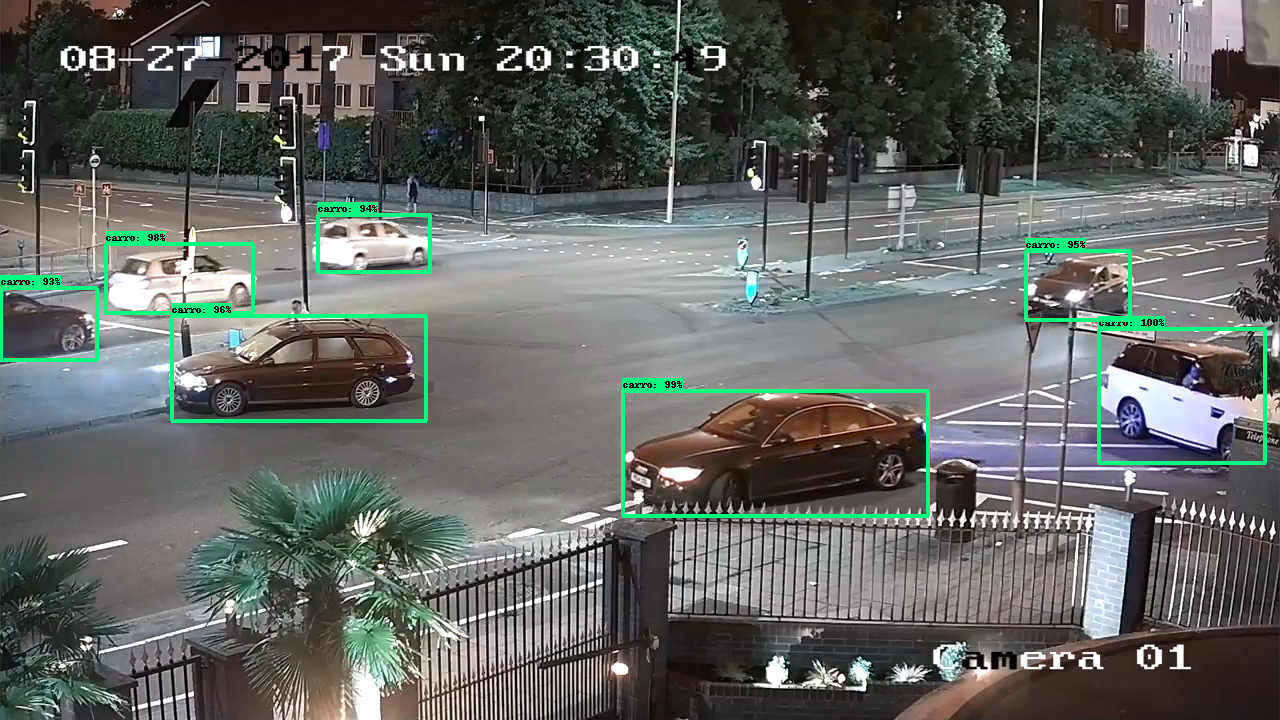

In [ ]:
# Receives an image and returns detection.
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

image_path = '/content/prueba5.png'

print('Running inference for {}... '.format(image_path), end='')

image_np = np.array(Image.open(image_path))

# The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
input_tensor = tf.convert_to_tensor(image_np)
# The model expects a batch of images, so add an axis with `tf.newaxis`.
input_tensor = input_tensor[tf.newaxis, ...]

# Perform detection
detections = detect_fn(input_tensor)
'''

dict_keys([
'raw_detection_boxes',
'detection_multiclass_scores',
'raw_detection_scores', 
'detection_anchor_indices', 
'detection_scores',
'detection_boxes',
'detection_classes',
'num_detections'])

'''

# Generate a preprocessing
num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections
# Class detection.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
image_np_with_detections = image_np.copy()
# Display settings
viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'],
      detections['detection_classes'],
      detections['detection_scores'],
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.30,
      agnostic_mode=False)
cv2_imshow(image_np_with_detections)

## Object Detection + Tracking

In [ ]:
import numpy as np
import argparse
import imutils
import time
import dlib
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from imutils.video import VideoStream
from imutils.video import FPS
from centroidtracker import CentroidTracker
from trackableobject import TrackableObject

In [ ]:
# Main arguments
#PATH_VIDEO = "/content/test_video.mp4"
PATH_VIDEO = "/content/crash.mp4"
#PATH_VIDEO = "/content/video1.mp4"
PATH_OUTPUT = "/content/video_out3.mp4"
SKIP_FPS = 30
TRESHOLD = 0.3

vs = cv2.VideoCapture(PATH_VIDEO)

# initialize the video writer (we'll instantiate later if need be)
writer = None

# initialize the frame dimensions (we'll set them as soon as we read
# the first frame from the video)
W = int(vs.get(cv2.CAP_PROP_FRAME_WIDTH))
H =  int(vs.get(cv2.CAP_PROP_FRAME_HEIGHT))



ct = CentroidTracker(maxDisappeared=40, maxDistance=50)
trackers = []
trackableObjects = {}

# initialize the total number of frames processed thus far, along
# with the total number of objects that have moved either up or down
totalFrames = 0
totalDown = 0
totalUp = 0

DIRECTION_PEOPLE = True



# [0,88,499,225]
# Starting point, width
POINT = [0, int((H/2)-H*0.1),W, int(H*0.1)]
# start the frames per second throughput estimator
fps = FPS().start()

print("[INFO] Iniciando detección en video...")

# if we are supposed to be writing a video to disk, initialize
# the writer
#fourcc = cv2.VideoWriter_fourcc(*"MJPG")
#writer = cv2.VideoWriter(PATH_OUTPUT, fourcc, 30, (W, H), True)

fourcc = cv2.VideoWriter_fourcc(*'MP4V') #codec
writer = cv2.VideoWriter(PATH_OUTPUT, fourcc, 20.0, (W, H), True)


# loop over frames from the video stream
while True:
  # grab the next frame and handle if we are reading from either
  # VideoCapture or VideoStream
  ret, frame = vs.read()

  # have reached the end of the video
  if frame is None:
    break

  #frame = imutils.resize(frame, width=500)
  #rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
  # if we are viewing a video and we did not grab a frame then we


  # resize the frame to have a maximum width of 500 pixels (the
  # less data we have, the faster we can process it), then convert
  # the frame from BGR to RGB for dlib
  

  # initialize the current status along with our list of bounding
  # box rectangles returned by either (1) our object detector or
  # (2) the correlation trackers
  status = "Waiting"
  rects = []

  # check to see if we should run a more computationally expensive
  # object detection method to aid our tracker
  if totalFrames % SKIP_FPS == 0:
    # set the status and initialize our new set of object trackers
    status = "Detecting"
    trackers = []

    # Integrate our ranking algorithms

    #image_np = np.array(Image.open(image_path))
    image_np = np.array(frame)

    # The input needs to be a tensor, convert it using `tf.convert_to_tensor`.
    input_tensor = tf.convert_to_tensor(image_np)
    # The model expects a batch of images, so add an axis with `tf.newaxis`.
    input_tensor = input_tensor[tf.newaxis, ...]

    # Perform detection
    detections = detect_fn(input_tensor)

    detection_scores = np.array(detections['detection_scores'][0])

    detection_clean = [x for x in detection_scores if x >= 0.5]
    
    # loop over the detections
    for x in range(len(detection_clean)):
      # extract the index of the class label from the
      # detections list

      idx = int(detections['detection_classes'][0][x])

      # compute the (x, y)-coordinates of the bounding box
      # for the object
            # [ymin, xmin, ymax, xmax]
      ymin, xmin, ymax, xmax = np.array(detections['detection_boxes'][0][x])
      box = [xmin, ymin, xmax, ymax] * np.array([W, H, W, H])
      #box = np.array(detections['detection_boxes'][0][x]) * np.array([W, H, W, H])
      #box = np.array(detections['detection_boxes'][0][x]) 
      (startX, startY, endX, endY) = box.astype("int")

      # construct a dlib rectangle object from the bounding
      # box coordinates and then start the dlib correlation
      # tracker
      tracker = dlib.correlation_tracker()
      rect = dlib.rectangle(startX, startY, endX, endY)
      tracker.start_track(frame, rect)

      # add the tracker to our list of trackers so we can
      # utilize it during skip frames
      trackers.append(tracker)


  # otherwise, we should utilize our object *trackers* rather than
  # object *detectors* to obtain a higher frame processing throughput
  else:
    # loop over the trackers
    for tracker in trackers:
      # set the status of our system to be 'tracking' rather
      # than 'waiting' or 'detecting'
      status = "Tracking"

      # update the tracker and grab the updated position
      tracker.update(frame)
      pos = tracker.get_position()

      # unpack the position object
      startX = int(pos.left())
      startY = int(pos.top())
      endX = int(pos.right())
      endY = int(pos.bottom())

      # add the bounding box coordinates to the rectangles list
      rects.append((startX, startY, endX, endY))

  # draw a horizontal line in the center of the frame -- once an
  # object crosses this line we will determine whether they were
  # moving 'up' or 'down'
  #cv2.line(frame, (0, H // 2), (W, H // 2), (0, 255, 255), 2)
  cv2.rectangle(frame, (POINT[0], POINT[1]), (POINT[0]+POINT[2], POINT[1]+POINT[3]), (255, 0, 255), 2)
                    

  # use the centroid tracker to associate the (1) old object
  # centroids with (2) the newly computed object centroids
  objects = ct.update(rects)

## ---------------------------------------- Second Part ----------------------------##

  # loop over the tracked objects
  for (objectID, centroid) in objects.items():
    # check to see if a trackable object exists for the current
    # object ID
    to = trackableObjects.get(objectID, None)

    # if there is no existing trackable object, create one
    if to is None:
      to = TrackableObject(objectID, centroid)

    # otherwise, there is a trackable object so we can utilize it
    # to determine direction
    else:
      # the difference between the y-coordinate of the *current*
      # centroid and the mean of *previous* centroids will tell
      # us in which direction the object is moving (negative for
      # 'up' and positive for 'down')
      y = [c[1] for c in to.centroids]
      direction = centroid[1] - np.mean(y)
      to.centroids.append(centroid)

      # check to see if the object has been counted or not
      if not to.counted:
        
        if centroid[0] > POINT[0] and centroid[0] < (POINT[0]+POINT[2]) and centroid[1] > POINT[1] and centroid[1] < (POINT[1]+POINT[3]):
          if DIRECTION_PEOPLE:
              if direction > 0:
                  totalUp += 1
                  personUp = 1
                  to.counted = True

              else:
                  totalDown += 1
                  personDown = 1
                  to.counted = True
          else:
            if direction < 0:
                totalUp += 1
                personUp = 1
                to.counted = True

            else:
                totalDown += 1
                personDown = 1
                to.counted = True
        '''
        if direction < 0 and centroid[1] < H // 2:
          totalUp += 1
          to.counted = True

        # if the direction is positive (indicating the object
        # is moving down) AND the centroid is below the
        # center line, count the object
        elif direction > 0 and centroid[1] > H // 2:
          totalDown += 1
          to.counted = True
          '''
        
        # if the direction is negative (indicating the object
        # is moving up) AND the centroid is above the center
        # line, count the object
       

        

    # store the trackable object in our dictionary
    trackableObjects[objectID] = to

    # draw both the ID of the object and the centroid of the
    # object on the output frame
    text = "ID {}".format(objectID)
    cv2.putText(frame, text, (centroid[0] - 10, centroid[1] - 10),
      cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)
    cv2.circle(frame, (centroid[0], centroid[1]), 4, (0, 255, 0), -1)
    
  # construct a tuple of information we will be displaying on the
  # frame
  info = [
    ("Subiendo", totalUp),
    ("Bajando", totalDown),
    ("Estado", status),
  ]

  # loop over the info tuples and draw them on our frame
  for (i, (k, v)) in enumerate(info):
    text = "{}: {}".format(k, v)
    cv2.putText(frame, text, (10, H - ((i * 20) + 20)),
      cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

  # check to see if we should write the frame to disk
  writer.write(frame)


  # increment the total number of frames processed thus far and
  # then update the FPS counter
  totalFrames += 1
  fps.update()

# stop the timer and display FPS information
fps.stop()
print("[INFO] elapsed time: {:.2f}".format(fps.elapsed()))
print("[INFO] approx. FPS: {:.2f}".format(fps.fps()))

# check to see if we need to release the video writer pointer

writer.release()

vs.release()

[INFO] Iniciando detección en video...
[INFO] elapsed time: 384.14
[INFO] approx. FPS: 18.47
